# Import Libraries

In [17]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Markdown
import os, sys, sqlite3

# LLM

In [18]:
from langchain_openai import ChatOpenAI

model_id = 'openai/gpt-4o-mini'
model_id = 'google/gemma-3-27b-it:free'
model_id = 'google/gemini-2.0-pro-exp-02-05:free'

llm = ChatOpenAI(model=model_id)
# llm.invoke("hi").pretty_print()

# 

Memory

In [19]:
database = './db/test.db'
conn = sqlite3.connect(database=database, check_same_thread=False)
memory = SqliteSaver(conn=conn)

State

In [20]:
class State(MessagesState):
    pass

Tools

In [21]:
def multiply(a: int, b: int) -> int:
    """Multiply a by b
    ouput: return number
    """
    return a * b

def add(a: int, b: int) -> int:
    """Add a by b
    ouput: return number
    """
    return a + b

tools = [multiply, add]

Node

In [22]:
llm_with_tools = llm.bind_tools(tools=tools)

def call_llm_tools(state: State):
    sys_msg = SystemMessage(content="You are a helful assistant help user with arithmatic operations.")
    messages = [sys_msg] + state['messages']
    return {'messages': llm_with_tools.invoke(messages)}

Graph

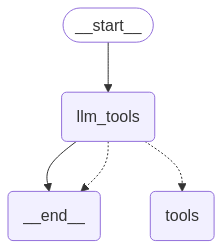

In [23]:
builder = StateGraph(State)
builder.add_node("llm_tools", call_llm_tools)
builder.add_node('tools', ToolNode(tools=tools))

# graph logic
builder.add_edge(START, 'llm_tools')
builder.add_conditional_edges('llm_tools', tools_condition)
builder.add_edge('llm_tools', END)

graph = builder.compile(checkpointer=memory)
graph

In [26]:
config = {"configurable" : {'thread_id': '1'}}

messages = [HumanMessage("What is 2 + 10?")]
res = graph.invoke({"messages": messages}, config=config)

for m in res['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 + 10?
================================== Ai Message ==================================
Tool Calls:
  add (call_VZndtjbvPPVVDciRsxu7SrGx)
 Call ID: call_VZndtjbvPPVVDciRsxu7SrGx
  Args:
    a: 2
    b: 10
================================ Human Message =================================

What is 2 + 10?
================================ Human Message =================================

What is 2 + 10?
================================ Human Message =================================

What is 2 + 10?
================================ Human Message =================================

What is 2 + 10?
================================ Human Message =================================

What is 2 + 10?
================================ Human Message =================================

What is 2 + 10?
================================== Ai Message ==================================
Tool Calls:
  add (tool_0_add)
 Cal